# Summary

This notebook contains a summary of the entire repository. It has been divided into different areas each explaining one aspect of our process. 

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import re
import glob
import math
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pyspark.sql.functions as F
import sklearn
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import *
from datetime import datetime, timedelta
from collections import defaultdict
from multiprocessing import Manager

In [2]:
spark = (
    SparkSession.builder.appName('Summary')
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '7g')
    .config('spark.executor.memory', '3g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/10/18 14:34:53 WARN Utils: Your hostname, DESKTOP-F216TKE resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/10/18 14:34:53 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/18 14:34:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Preprocessing

On preprocessing all the data the following records are left in the dataset

In [3]:
tbl_merchants = spark.read.parquet('.././data/curated/tbl_merchants')

In [4]:
tbl_merchants.count()

4026

There are 4026 distinct merchants

In [5]:
tbl_consumers = spark.read.parquet('.././data/curated/tbl_consumer')

In [6]:
tbl_consumers.count()

499999

There are 499999 consumers

In [7]:
full_transactions = spark.read.parquet('.././data/curated/full_transactions')

In [8]:
full_transactions.count()

13614854

There are nearly 13614854 trsanctions from Febraury 28th 2021 to October 26th 2022

All tables have been checked to ensure that all records are valid. The transaction dataframe had merchants that were invalid and those were removed 

Joining the original data:
The data had been joined based on order_datetime and id's for merchants and consumers

In [9]:
full_transactions.printSchema()

root
 |-- order_datetime: date (nullable = true)
 |-- merchant_abn: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- fraud_probability: double (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- type: string (nullable = true)
 |-- take_rate: double (nullable = true)
 |-- merchant_fraud_probability: double (nullable = true)



In [10]:
full_transactions.filter(F.isnull('merchant_fraud_probability')).count()

13610826

In [11]:
full_transactions.filter(F.isnull('fraud_probability')).count()

13543038

13610826 merchant frauds were null and 13543038 consumer frauds were null

## External datasets:
**Census Data:** This data was combined with our original data using consumer postocde and was used to retrieve features such as household size, family earnings and age.

**Retail Sales Data:** Seasonal retail sales based on month and year for states was added. 

In [12]:
transactions = spark.read.parquet('.././data/curated/transaction_external')

In [13]:
transactions.show()

24/10/18 14:35:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+----+--------+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+------+-----------------+--------------------+--------------------+----+---------+--------------------------+----------+--------------+----------------+------------------+-------------------+------------------+-------------------------+-------------------------+----------------------+-------+-------+-------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+------------+------------+------------+-----------+-----------+------------+-----------+------------+--------------+
|month|year|postcode|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|     consumer_name|state|gender|fraud_probability|       merchant_name|                tags|type|take_rate|merchant_fraud_probability|AREASQKM21|    SHAPE_Leng|      SHAPE_Area|               lon|                lat

In [14]:
transactions.printSchema()

root
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- postcode: integer (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- merchant_abn: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- dollar_value: double (nullable = true)
 |-- order_id: string (nullable = true)
 |-- consumer_name: string (nullable = true)
 |-- state: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- fraud_probability: double (nullable = true)
 |-- merchant_name: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- type: string (nullable = true)
 |-- take_rate: double (nullable = true)
 |-- merchant_fraud_probability: double (nullable = true)
 |-- AREASQKM21: double (nullable = true)
 |-- SHAPE_Leng: double (nullable = true)
 |-- SHAPE_Area: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- lat: double (nullable = true)
 |-- Median_age_persons: double (nullable = 

The above dataframe contains the combined orginal data with external datasets

## Findings

This section contains a summary on the features studied. While a feature may have been studied based on the analysis they may or may not have been used in the final model 

The number of merchants in each tag lies between a range of 90 to 180

In [15]:
tbl_merchants.groupBy('tags').agg(F.count('*').alias('Number of tags')).summary()

+-------+--------------------+-----------------+
|summary|                tags|   Number of tags|
+-------+--------------------+-----------------+
|  count|                  25|               25|
|   mean|                NULL|           161.04|
| stddev|                NULL|26.59492432777352|
|    min|antique, repairs,...|               91|
|    25%|                NULL|              151|
|    50%|                NULL|              167|
|    75%|                NULL|              181|
|    max|watch, clock, jew...|              195|
+-------+--------------------+-----------------+

In [16]:
pdf = tbl_merchants.groupBy('tags').agg(F.count('*').alias('Number of tags')).pandas_api()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [17]:
pdf.plot.bar('tags', 'Number of tags')

The graph shows that while they might vary most of them are of a similar number

## Merchant and Consumer Fraud 

In [18]:
filtered = spark.read.parquet('.././data/curated/filtered')

In [19]:
filtered.printSchema()

root
 |-- merchant_abn: string (nullable = true)
 |-- tags: string (nullable = true)
 |-- take_rate: double (nullable = true)
 |-- type: string (nullable = true)
 |-- Total Revenue: double (nullable = true)
 |-- Total Sales: long (nullable = true)
 |-- Merchant Fraud: double (nullable = true)
 |-- Consumer Fraud: double (nullable = true)
 |-- Median Family Income: double (nullable = true)
 |-- avg(seasonal_sales): double (nullable = true)
 |-- avg(original_sales): double (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- Unique Customers: long (nullable = true)
 |-- Average Expected Revenue: double (nullable = true)
 |-- Days with Sales: long (nullable = true)



In [20]:
pdf = filtered.toPandas()

<Figure size 800x600 with 0 Axes>

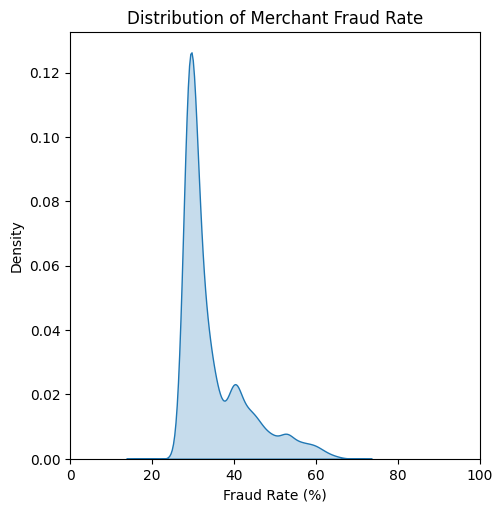

In [21]:
plt.figure(figsize=(8, 6), frameon=False)
sns.displot(data = pdf, x='Merchant Fraud', bw_adjust=1, kind="kde", common_norm=False, legend=False, fill=True)
ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Merchant Fraud Rate")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("Density")
plt.xlim((0, 100))
plt.xlim(0)

plt.show()

Merchant Fraud Rate had a 90% presence between 20-50% and all outliers >50% were removed 

<Figure size 800x600 with 0 Axes>

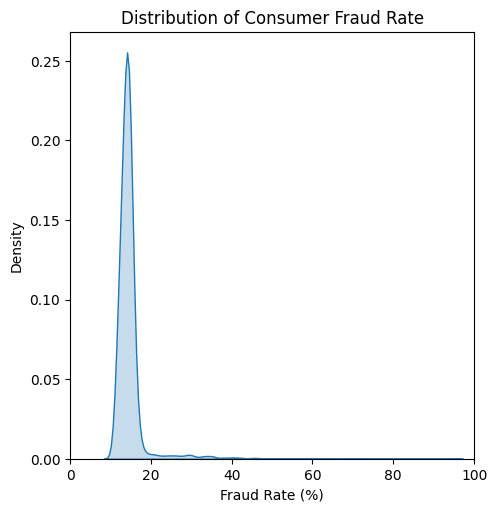

In [22]:
plt.figure(figsize=(8, 6), frameon=False)
sns.displot(data = pdf, x='Consumer Fraud', bw_adjust=1, kind="kde", common_norm=False, legend=False, fill=True)
ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Consumer Fraud Rate")
plt.xlabel("Fraud Rate (%)")
plt.ylabel("Density")
plt.xlim((0, 100))
plt.xlim(0)

plt.show()

Consumer Fraud Rate was lower than merchant fraud rate lying between 10-17% and outliers were not removed with the expectation that the model would remove them. 

## Unique Customers 

In [23]:
import plotly.express as px

In [24]:
fig = px.scatter(pdf, y = 'Total Revenue', x = 'Unique Customers',  hover_data=['merchant_abn', 'tags'], title='Unique Customers and Revenue for Merchants')
fig.update_layout(title_x = 0.5)
fig.show()

From the above graph it can be inferred that there are merchants with more customers who less revenue and those with less customers but high revenue.

An example of this is merchants with the tag telecom who have less customers but make earnings in the millions since they recieved regular steady payments over the entire time period of the data.

## Location

As according to the readme there is an equal number of consumers from all states and merchants have the same proportion of consumers geographically from different states. This can be seen from the density graphs made for each state below. 

In [25]:
full_transactions.show()

+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+----+---------+--------------------------+
|order_datetime|merchant_abn|user_id|consumer_id|      dollar_value|            order_id|     consumer_name|state|postcode|gender|fraud_probability|       merchant_name|                tags|type|take_rate|merchant_fraud_probability|
+--------------+------------+-------+-----------+------------------+--------------------+------------------+-----+--------+------+-----------------+--------------------+--------------------+----+---------+--------------------------+
|    2022-08-25| 63290521567|  11138|     401483|41.239626303220014|09f6132a-a6a8-47a...|   Veronica Nelson|   WA|    6519|Female|             NULL|Vehicula Pellente...|artist supply, craft|   a|     6.48|                      NULL|
|    2022-08-25| 63465140133|  22285|     416278| 8.815286645396842|

In [26]:
by_state = full_transactions.groupBy('merchant_abn', 'state').agg(F.count('*').alias('Sales by State'))

In [27]:
sales = full_transactions.groupBy('merchant_abn').agg(F.count('*').alias('Sales'))

In [28]:
sales.show()

+------------+-----+
|merchant_abn|Sales|
+------------+-----+
| 67165527084| 1280|
| 60978195146|27543|
| 33651513345| 2524|
| 53074973777|  251|
| 37629693091|  455|
| 90976587185|   43|
| 36866208934| 1074|
| 97088280855|  232|
| 21552853184|  280|
| 31245723081|  416|
| 73792600690|  205|
| 33026294208|  182|
| 11633090957|  333|
| 87092867947|  126|
| 70713877189|  232|
| 60963420870|   85|
| 76618399784|   18|
| 95824231566|   16|
| 87284273126|   39|
| 86137100428|   32|
+------------+-----+
only showing top 20 rows



In [29]:
proportions = sales.join(by_state, on='merchant_abn')

In [30]:
proportions = proportions.withColumn('proportions', (F.col('Sales by State')/F.col('Sales')) * 100)

In [31]:
proportions.printSchema()

root
 |-- merchant_abn: string (nullable = true)
 |-- Sales: long (nullable = false)
 |-- state: string (nullable = true)
 |-- Sales by State: long (nullable = false)
 |-- proportions: double (nullable = true)



In [32]:
nsw = proportions.filter(F.col('state') == 'NSW')

In [33]:
nt = proportions.filter(F.col('state') == 'NT').toPandas()
act = proportions.filter(F.col('state') == 'ACT').toPandas()
sa = proportions.filter(F.col('state') == 'SA').toPandas()
tas = proportions.filter(F.col('state') == 'TAS').toPandas()
wa = proportions.filter(F.col('state') == 'WA').toPandas()
qld = proportions.filter(F.col('state') == 'QLD').toPandas()
vic = proportions.filter(F.col('state') == 'VIC').toPandas()

In [34]:
nswdf = nsw.toPandas()

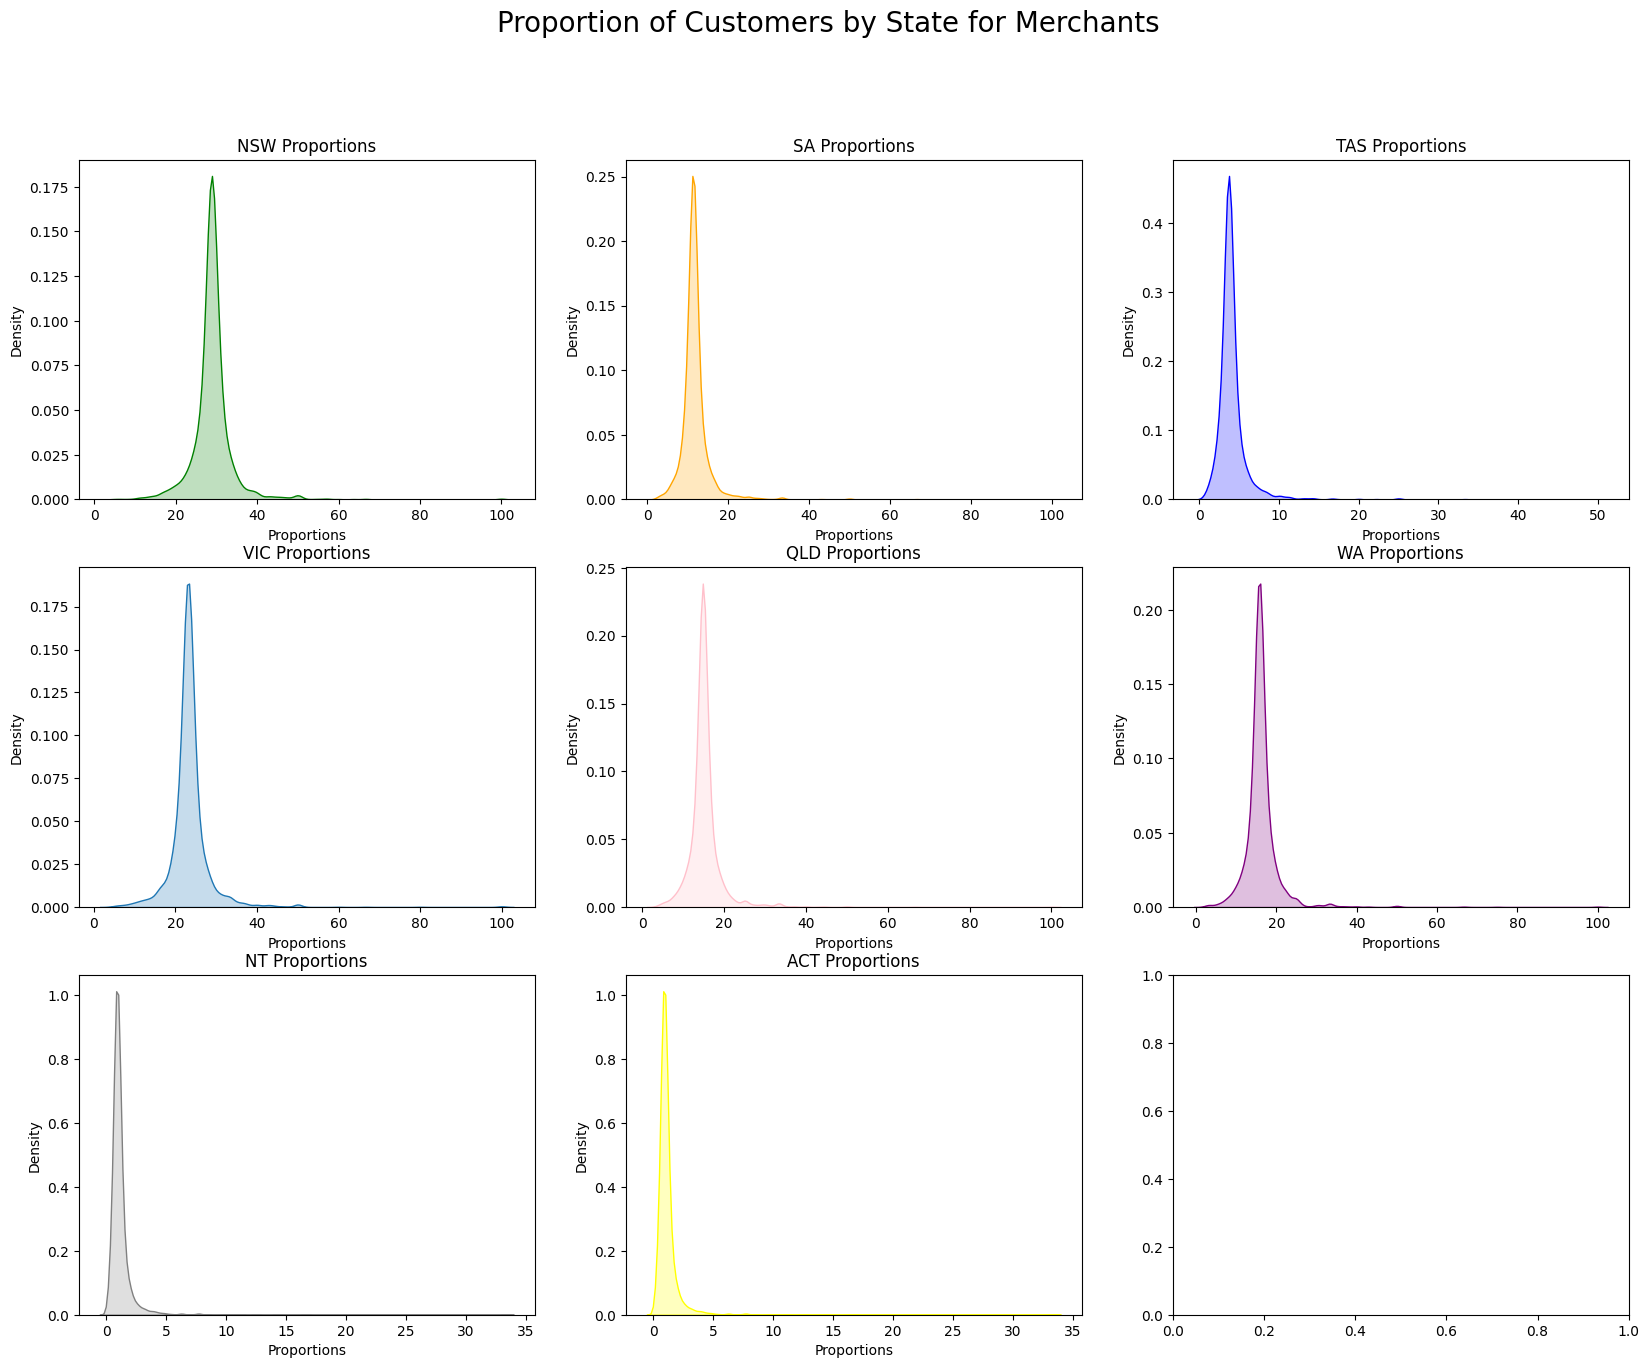

In [37]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))

fig.suptitle('Proportion of Customers by State for Merchants', fontsize = 20)
sns.kdeplot(ax=axes[0, 0], data = nswdf, x='proportions', bw_adjust=1, common_norm=False, legend=False, fill=True, color = 'green')
axes[0, 0].set_title('NSW Proportions')
axes[0, 0].set_xlabel('Proportions')
axes[0, 0].set_ylabel('Density')
sns.kdeplot(ax=axes[1, 0], data = vic, x='proportions', bw_adjust=1, common_norm=False, legend=False, fill=True)
axes[1, 0].set_title('VIC Proportions')
axes[1, 0].set_xlabel('Proportions')
axes[1, 0].set_ylabel('Density')
sns.kdeplot(ax=axes[1, 1], data = qld, x='proportions', bw_adjust=1, common_norm=False, legend=False, fill=True, color = 'pink')
axes[1, 1].set_title('QLD Proportions')
axes[1, 1].set_xlabel('Proportions')
axes[1, 1].set_ylabel('Density')
sns.kdeplot(ax=axes[1, 2], data = wa, x='proportions', bw_adjust=1, common_norm=False, legend=False, fill=True, color = 'purple')
axes[1, 2].set_title('WA Proportions')
axes[1, 2].set_xlabel('Proportions')
axes[1, 2].set_ylabel('Density')
sns.kdeplot(ax=axes[0,1], data = sa, x='proportions', bw_adjust=1, common_norm=False, legend=False, fill=True, color = 'orange')
axes[0, 1].set_title('SA Proportions')
axes[0, 1].set_xlabel('Proportions')
axes[0, 1].set_ylabel('Density')
sns.kdeplot(ax=axes[0,2], data = tas, x='proportions', bw_adjust=1, common_norm=False, legend=False, fill=True, color = 'blue')
axes[0, 2].set_title('TAS Proportions')
axes[0, 2].set_xlabel('Proportions')
axes[0, 2].set_ylabel('Density')
sns.kdeplot(ax=axes[2,1], data = act, x='proportions', bw_adjust=1, common_norm=False, legend=False, fill=True, color = 'yellow')
axes[2, 1].set_title('ACT Proportions')
axes[2, 1].set_xlabel('Proportions')
axes[2, 1].set_ylabel('Density')
sns.kdeplot(ax=axes[2,0], data = act, x='proportions', bw_adjust=1, common_norm=False, legend=False, fill=True, color = 'grey')
axes[2, 0].set_title('NT Proportions')
axes[2, 0].set_xlabel('Proportions')
axes[2, 0].set_ylabel('Density')
plt.show()


We decided to remove merchants with fraud probabilities > 50%, as these merchants were on the higher end of fraud probabilities, and it was decided these merchants would be unreliable. In other cases, our key ranking metric (`expected revenue = (1 - merchant fraud probability) * (1 - consumer fraud probability) * take rate * dollar value`) would be able to handle small dollar values or small take rates, as these merchants would be expected to be ranked much lower by our model.

# Ranking
Our top 100 ranking is below. We can see the top 100 merchants here have significantly greater revenue than the general merchant population, and have greater take rates, which make them attractive to onboard.

In fact, 9 of the top 10 merchants have take rates greater than 6%.

More details are available in `rankings.ipynb`.

24/10/17 22:16:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/17 22:16:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/17 22:16:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/10/17 22:16:55 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


<Figure size 800x600 with 0 Axes>

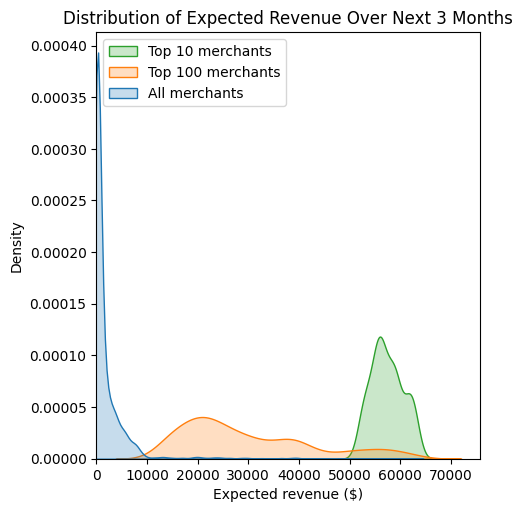

In [37]:
rankings = spark.read.parquet("../data/curated/rankings.parquet", inferSchema=True)

window_spec = Window.orderBy(F.desc("expected_revenue_predicted_sum"))

removed_fraud = rankings.where(F.col("merchant_mean_merchant_fraud_probability") < 50.0)

removed_fraud = removed_fraud.withColumn("row_num", F.row_number().over(window_spec)) \
    .withColumn("is_first_100", F.when(F.col("row_num") <= 100, 1).otherwise(0)) \
    .drop("row_num")

removed_fraud = removed_fraud.withColumn("row_num", F.row_number().over(window_spec)) \
    .withColumn("is_first_10", F.when(F.col("row_num") <= 10, 1).otherwise(0)) \
    .drop("row_num")

removed_fraud = removed_fraud.sort(F.col("expected_revenue_predicted_sum").desc()).toPandas()

all_merchants = removed_fraud.copy()
all_merchants['subset'] = 'All merchants'

top_100_merchants = removed_fraud.iloc[:100].copy()
top_100_merchants['subset'] = 'Top 100 merchants'

top_10_merchants = removed_fraud.iloc[:10].copy()
top_10_merchants['subset'] = 'Top 10 merchants'

merged_data = pd.concat([all_merchants, top_100_merchants, top_10_merchants])

plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='expected_revenue_predicted_sum', hue="subset", 
    bw_adjust=0.6, kind="kde", common_norm=False, legend=False, fill=True)

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Expected Revenue Over Next 3 Months")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper left")
plt.xlabel("Expected revenue ($)")
plt.ylabel("Density")
plt.xlim(0)

plt.show()

<Figure size 800x600 with 0 Axes>

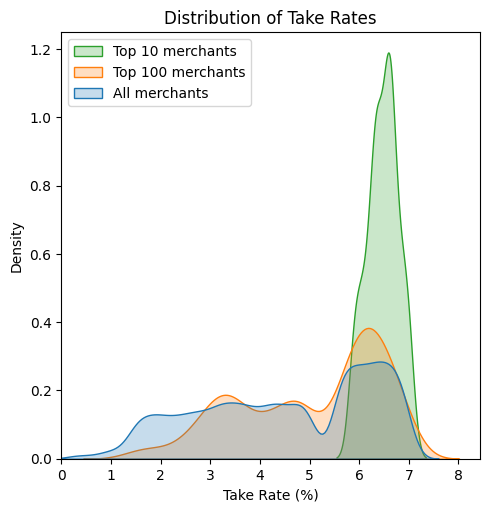

In [36]:
plt.figure(figsize=(8, 6), frameon=False)
ax = sns.displot(data=merged_data, x='take_rate', hue="subset", bw_adjust=0.6, kind="kde", common_norm=False, legend=False, fill=True)

ax = plt.gca()
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)
ax.spines["left"].set_visible(True)

plt.title("Distribution of Take Rates")
plt.legend(['Top 10 merchants', 'Top 100 merchants', 'All merchants'], loc="upper left")
plt.xlabel("Take Rate (%)")
plt.ylabel("Density")
plt.xlim(0)

plt.show()

Below are our top 100 merchants.

In [41]:
rankings.select(
    "merchant_abn", 
    "merchant_name", 
    "expected_revenue_predicted_sum", 
    "take_rate", 
    "merchant_num_sales",
    "row_num", 
).withColumnRenamed("expected_revenue_predicted_sum", "expected_revenue_over_next_3_months") \
    .withColumnRenamed("row_num", "rank") \
    .withColumnRenamed("merchant_num_sales", "number_of_sales") \
    .show(100, truncate=False)

+------------+---------------------------------+-----------------------------------+---------+---------------+----+
|merchant_abn|merchant_name                    |expected_revenue_over_next_3_months|take_rate|number_of_sales|rank|
+------------+---------------------------------+-----------------------------------+---------+---------------+----+
|79827781481 |Amet Risus Inc.                  |62673.40005493164                  |6.82     |3997           |1   |
|48534649627 |Dignissim Maecenas Foundation    |61505.107513427734                 |6.64     |55666          |2   |
|86578477987 |Leo In Consulting                |59377.41116333008                  |6.43     |227775         |3   |
|38700038932 |Etiam Bibendum Industries        |58785.243713378906                 |6.31     |5944           |4   |
|32361057556 |Orci In Consequat Corporation    |57547.63864135742                  |6.61     |71720          |5   |
|96680767841 |Ornare Limited                   |56324.977966308594      

# Segmentation
We segmented merchants across the number of sales they made and their average transaction value using KMeans.

The following plot shows the segmentation and the general distribution of estimated expected revenue for the next 3 months for each segment, ignoring the outliers.

More details are available in `rankings.ipynb`.

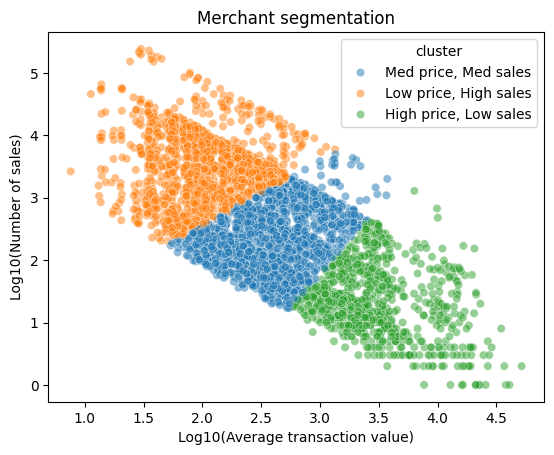

In [19]:
segments = rankings.select("cluster", "merchant_mean_dollar_value", "merchant_num_sales").toPandas()

segments['merchant_mean_dollar_value'] = np.log10(segments['merchant_mean_dollar_value'])
segments['merchant_num_sales'] = np.log10(segments['merchant_num_sales'])

sns.scatterplot(segments, x='merchant_mean_dollar_value', y='merchant_num_sales', hue='cluster', alpha=0.5)
plt.title("Merchant segmentation")
plt.xlabel("Log10(Average transaction value)")
plt.ylabel("Log10(Number of sales)")
plt.show()

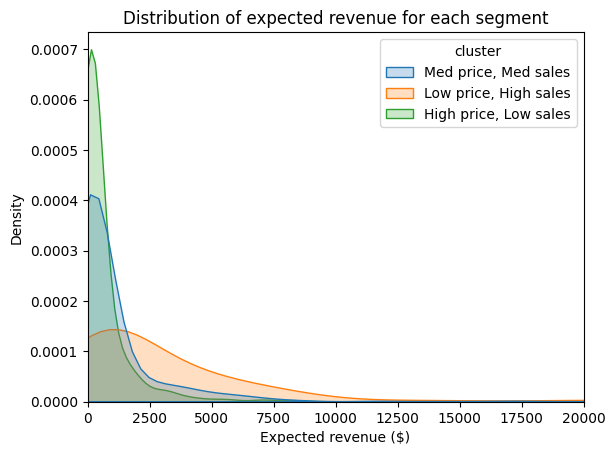

In [20]:
segments = rankings.select("expected_revenue_predicted_sum", "cluster", "take_rate").toPandas()
sns.kdeplot(segments, x='expected_revenue_predicted_sum', hue='cluster', fill=True, common_norm=False)
plt.title("Distribution of expected revenue for each segment")
plt.xlabel("Expected revenue ($)")
plt.ylabel("Density")
plt.xlim((0, 20000))

plt.show()

From these graphs, we can see the low price, high sales segment will generally earn us more revenue, so merchants from this segment should be chosen if our goal is purely to maximise revenue. 

The high price, low sales segment does present an advantage in growth however, as we expect products with higher transaction values to experience a greater boost in conversion rate (and subsequently our expected revenue) when BNPL options are available for these products.

Below are our top 10 merchants ranked for each segment.

In [32]:
segments = rankings.select(
    "merchant_abn", 
    "merchant_name", 
    "expected_revenue_predicted_sum", 
    "cluster", 
    "row_num"
)

window = Window.partitionBy("cluster").orderBy(F.col("expected_revenue_predicted_sum").desc())
segments = segments.withColumn("rank", F.row_number().over(window)) \
    .withColumnRenamed("row_num", "overall_rank") \
    .withColumnRenamed("expected_revenue_predicted_sum", "expected_revenue_next_3_months")
segments = segments.filter(segments.rank <= 10)
segments.show(30, truncate=False)

+------------+------------------------------+------------------------------+---------------------+------------+----+
|merchant_abn|merchant_name                 |expected_revenue_next_3_months|cluster              |overall_rank|rank|
+------------+------------------------------+------------------------------+---------------------+------------+----+
|31334588839 |Lacus Aliquam Corporation     |28444.067352294922            |High price, Low sales|44          |1   |
|19492220327 |Commodo Ipsum Industries      |24387.230682373047            |High price, Low sales|56          |2   |
|90918180829 |Pharetra Quisque Company      |8483.027931213379             |High price, Low sales|146         |3   |
|83199298021 |Ligula Elit Pretium Foundation|8107.491165161133             |High price, Low sales|161         |4   |
|15043504837 |Odio Incorporated             |7275.490550994873             |High price, Low sales|214         |5   |
|12741443840 |Tincidunt Aliquam Limited     |7170.174125671387  